# Flag Analysis for NOAA GHCN-Daily Data

This notebook analyzes the MFLAG, QFLAG, and SFLAG fields in the by_year parquet files to understand data quality and source information.

## Flag Definitions:
- **MFLAG**: Measurement flag (B=12hr totals, D=6hr totals, H=hourly, etc.)
- **QFLAG**: Quality flag (D=duplicate, G=gap, I=internal consistency, etc.)
- **SFLAG**: Source flag (0=US Cooperative, A=ASOS, S=Global Summary, etc.)


In [1]:
# Import required libraries
import s3fs
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette('husl')
%matplotlib inline

print('✓ Libraries imported successfully!')


✓ Libraries imported successfully!


In [2]:
# Setup S3 connection
s3 = s3fs.S3FileSystem(anon=True)
bucket_path = 's3://noaa-ghcn-pds/parquet/by_year/'

print('✓ S3 connection established')


✓ S3 connection established


In [3]:
# Load sample data from multiple years and elements
print("Loading sample data for flag analysis...")

# Define sample years and elements
sample_years = [2020, 2021, 2022]
sample_elements = ['TOBS', 'TMAX', 'TMIN', 'PRCP']

all_files = []
for year in sample_years:
    for element in sample_elements:
        file_path = f"{bucket_path}YEAR={year}/ELEMENT={element}/"
        files = s3.glob(f"{file_path}*.parquet")
        if files:
            all_files.extend([f"s3://{f}" for f in files])

print(f"Found {len(all_files)} parquet files to analyze")

# Load data with Dask using the working approach
if all_files:
    try:
        print("Loading data with Dask...")
        df = dd.read_parquet(all_files, storage_options={'anon': True})
        print(f"✓ Loaded data: {len(df):,} records, {df.npartitions} partitions")
        print(f"Columns: {list(df.columns)}")
        print(f"df type: {type(df)}")
        
        # Check if we have the expected flag columns
        expected_flags = ['M_FLAG', 'Q_FLAG', 'S_FLAG']
        missing_flags = [flag for flag in expected_flags if flag not in df.columns]
        if missing_flags:
            print(f"⚠️  Missing flag columns: {missing_flags}")
            print(f"Available columns: {list(df.columns)}")
        else:
            print("✓ All expected flag columns found")
            
        # Test that df is accessible
        print(f"✓ df variable created successfully: {type(df)}")
            
    except Exception as e:
        print(f"✗ Error loading data: {e}")
        import traceback
        traceback.print_exc()
        print("Trying alternative approach...")
        
        # Try loading just one file to test
        if all_files:
            try:
                print(f"Trying to load single file: {all_files[0]}")
                test_df = dd.read_parquet(all_files[0], storage_options={'anon': True})
                print(f"✓ Test load successful: {len(test_df):,} records")
                print(f"Test columns: {list(test_df.columns)}")
                df = test_df  # Use single file for analysis
                print(f"✓ df variable set to test_df: {type(df)}")
            except Exception as e2:
                print(f"✗ Test load failed: {e2}")
                import traceback
                traceback.print_exc()
else:
    print("✗ No files found")


Loading sample data for flag analysis...
Found 91 parquet files to analyze
Loading data with Dask...
✓ Loaded data: 43,259,957 records, 91 partitions
Columns: ['ID', 'DATE', 'DATA_VALUE', 'M_FLAG', 'Q_FLAG', 'S_FLAG', 'OBS_TIME', 'YEAR', 'ELEMENT']
df type: <class 'dask.dataframe.core.DataFrame'>
✓ All expected flag columns found
✓ df variable created successfully: <class 'dask.dataframe.core.DataFrame'>


In [4]:
# Analyze flag distributions
print("FLAG DISTRIBUTION ANALYSIS")
print("=" * 50)

# Initialize variables to avoid NameError in subsequent cells
df_sample = None
sample_size = 100000

try:
    # Check if df is defined and is a Dask DataFrame
    if 'df' not in locals():
        print("✗ Error: df not defined. Please run the data loading cell first.")
        df_sample = pd.DataFrame()
    else:
        print(f"df type: {type(df)}")
        print(f"df length: {len(df):,} records")
        print(f"df columns: {list(df.columns)}")
        
        # Get sample for analysis (to avoid memory issues)
        # For Dask DataFrame, head() returns a pandas DataFrame
        print("Getting sample data...")
        df_sample = df.head(sample_size)
        print(f"df_sample type: {type(df_sample)}")
        print(f"Analyzing sample of {len(df_sample):,} records")
    
    # Analyze each flag type
    flag_columns = ['M_FLAG', 'Q_FLAG', 'S_FLAG']
    
    for flag_col in flag_columns:
        if flag_col in df_sample.columns:
            print(f"\n{flag_col} Analysis:")
            print("-" * 30)
            
            # Count non-null values
            non_null_count = df_sample[flag_col].notna().sum()
            null_count = df_sample[flag_col].isna().sum()
            total_count = len(df_sample)
            
            print(f"Non-null values: {non_null_count:,} ({non_null_count/total_count*100:.1f}%)")
            print(f"Null values: {null_count:,} ({null_count/total_count*100:.1f}%)")
            
            if non_null_count > 0:
                # Value counts
                value_counts = df_sample[flag_col].value_counts()
                print(f"\nTop 10 values:")
                for value, count in value_counts.head(10).items():
                    pct = count / non_null_count * 100
                    print(f"  {value}: {count:,} ({pct:.1f}%)")
            
            print(f"\nUnique values: {df_sample[flag_col].nunique()}")
        else:
            print(f"\n{flag_col} not found in data")
            
except Exception as e:
    print(f"✗ Error in flag analysis: {e}")
    print("Available columns:", list(df.columns) if 'df' in locals() else "No data loaded")
    # Create empty DataFrame as fallback
    df_sample = pd.DataFrame()


FLAG DISTRIBUTION ANALYSIS
df type: <class 'dask.dataframe.core.DataFrame'>
df length: 43,259,957 records
df columns: ['ID', 'DATE', 'DATA_VALUE', 'M_FLAG', 'Q_FLAG', 'S_FLAG', 'OBS_TIME', 'YEAR', 'ELEMENT']
Getting sample data...
df_sample type: <class 'pandas.core.frame.DataFrame'>
Analyzing sample of 100,000 records

M_FLAG Analysis:
------------------------------
Non-null values: 6,463 (6.5%)
Null values: 93,537 (93.5%)

Top 10 values:
  T: 3,920 (60.7%)
  B: 2,501 (38.7%)
  D: 42 (0.6%)

Unique values: 3

Q_FLAG Analysis:
------------------------------
Non-null values: 131 (0.1%)
Null values: 99,869 (99.9%)

Top 10 values:
  L: 48 (36.6%)
  Z: 37 (28.2%)
  K: 29 (22.1%)
  D: 8 (6.1%)
  O: 5 (3.8%)
  I: 3 (2.3%)
  G: 1 (0.8%)

Unique values: 7

S_FLAG Analysis:
------------------------------
Non-null values: 100,000 (100.0%)
Null values: 0 (0.0%)

Top 10 values:
  N: 38,483 (38.5%)
  7: 18,995 (19.0%)
  a: 16,918 (16.9%)
  E: 7,794 (7.8%)
  S: 6,036 (6.0%)
  W: 4,253 (4.3%)
  C: 3,


FLAG DISTRIBUTION VISUALIZATIONS


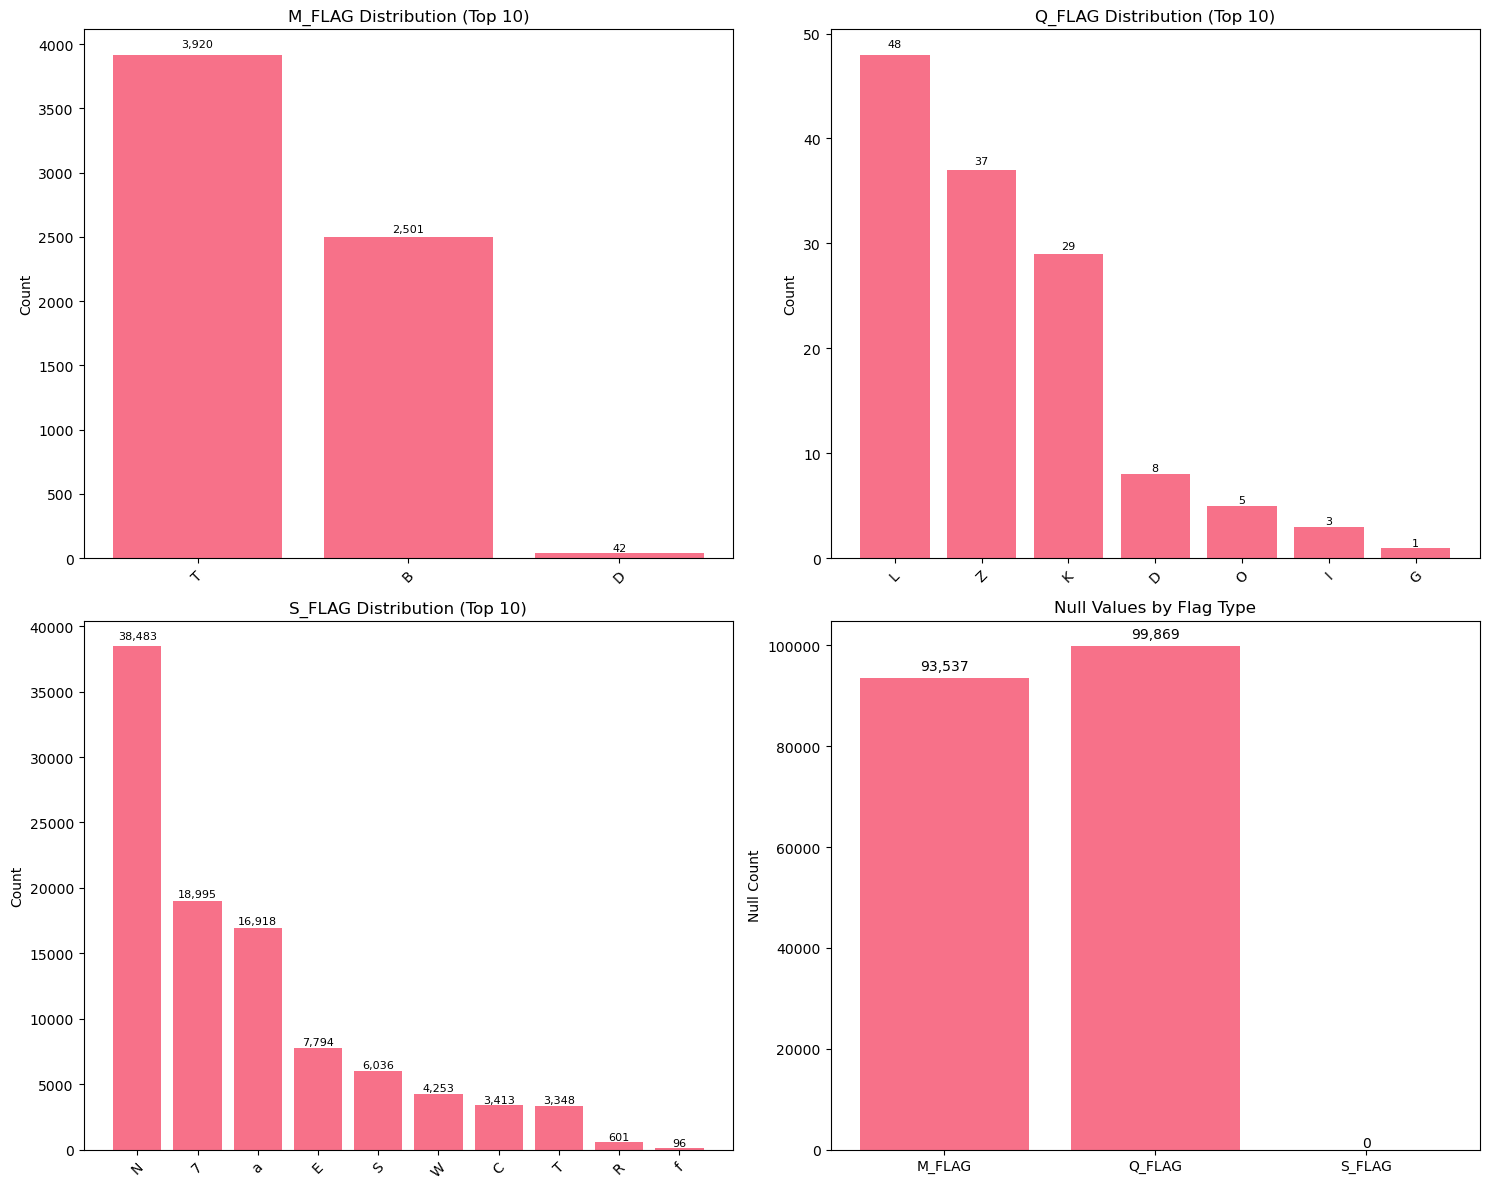

In [5]:
# Visualize flag distributions
print("\nFLAG DISTRIBUTION VISUALIZATIONS")
print("=" * 50)

try:
    if df_sample is None or df_sample.empty:
        print("No data available for visualization")
    else:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()
        
        flag_columns = ['M_FLAG', 'Q_FLAG', 'S_FLAG']
        
        for i, flag_col in enumerate(flag_columns):
            if flag_col in df_sample.columns:
                ax = axes[i]
                
                # Get non-null values
                flag_data = df_sample[flag_col].dropna()
                
                if len(flag_data) > 0:
                    # Plot top 10 values
                    value_counts = flag_data.value_counts().head(10)
                    
                    bars = ax.bar(range(len(value_counts)), value_counts.values)
                    ax.set_xticks(range(len(value_counts)))
                    ax.set_xticklabels(value_counts.index, rotation=45)
                    ax.set_title(f'{flag_col} Distribution (Top 10)')
                    ax.set_ylabel('Count')
                    
                    # Add value labels on bars
                    for bar, count in zip(bars, value_counts.values):
                        height = bar.get_height()
                        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                               f'{count:,}', ha='center', va='bottom', fontsize=8)
                else:
                    ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'{flag_col} Distribution')
            else:
                ax.text(0.5, 0.5, 'Column not found', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{flag_col} Distribution')
        
        # Null values comparison
        ax = axes[3]
        null_counts = []
        flag_names = []
        for flag_col in flag_columns:
            if flag_col in df_sample.columns:
                null_count = df_sample[flag_col].isna().sum()
                null_counts.append(null_count)
                flag_names.append(flag_col)
        
        if null_counts:
            bars = ax.bar(flag_names, null_counts)
            ax.set_title('Null Values by Flag Type')
            ax.set_ylabel('Null Count')
            
            # Add value labels
            for bar, count in zip(bars, null_counts):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{count:,}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
    
except Exception as e:
    print(f"✗ Error in visualization: {e}")
    print("Skipping visualization due to error")


In [6]:
# Quality flag analysis (QFLAG)
print("\nQUALITY FLAG (QFLAG) DETAILED ANALYSIS")
print("=" * 50)

try:
    if df_sample is None or df_sample.empty:
        print("No data available for QFLAG analysis")
    elif 'Q_FLAG' in df_sample.columns:
        qflag_data = df_sample['Q_FLAG'].dropna()
        
        if len(qflag_data) > 0:
            print(f"Records with quality flags: {len(qflag_data):,}")
            print(f"Percentage of total: {len(qflag_data)/len(df_sample)*100:.1f}%")
            
            # Quality flag meanings
            qflag_meanings = {
                'D': 'Failed duplicate check',
                'G': 'Failed gap check',
                'I': 'Failed internal consistency check',
                'K': 'Failed streak/frequent-value check',
                'L': 'Failed check on length of multiday period',
                'M': 'Failed megaconsistency check',
                'N': 'Failed naught check',
                'O': 'Failed climatological outlier check',
                'R': 'Failed lagged range check',
                'S': 'Failed spatial consistency check',
                'T': 'Failed temporal consistency check',
                'W': 'Temperature too warm for snow',
                'X': 'Failed bounds check',
                'Z': 'Flagged as a result of an official Datzilla investigation'
            }
            
            print("\nQuality flag breakdown:")
            print("-" * 40)
            value_counts = qflag_data.value_counts()
            for flag, count in value_counts.items():
                pct = count / len(qflag_data) * 100
                meaning = qflag_meanings.get(flag, 'Unknown')
                print(f"  {flag}: {count:,} ({pct:.1f}%) - {meaning}")
        else:
            print("No quality flags found in sample")
    else:
        print("Q_FLAG column not found in data")
        
except Exception as e:
    print(f"✗ Error in QFLAG analysis: {e}")
    print("Available columns:", list(df_sample.columns) if 'df_sample' in locals() and df_sample is not None else "No sample data")



QUALITY FLAG (QFLAG) DETAILED ANALYSIS
Records with quality flags: 131
Percentage of total: 0.1%

Quality flag breakdown:
----------------------------------------
  L: 48 (36.6%) - Failed check on length of multiday period
  Z: 37 (28.2%) - Flagged as a result of an official Datzilla investigation
  K: 29 (22.1%) - Failed streak/frequent-value check
  D: 8 (6.1%) - Failed duplicate check
  O: 5 (3.8%) - Failed climatological outlier check
  I: 3 (2.3%) - Failed internal consistency check
  G: 1 (0.8%) - Failed gap check


In [7]:
# Source flag analysis (SFLAG)
print("\nSOURCE FLAG (SFLAG) DETAILED ANALYSIS")
print("=" * 50)

try:
    if df_sample is None or df_sample.empty:
        print("No data available for SFLAG analysis")
    elif 'S_FLAG' in df_sample.columns:
        sflag_data = df_sample['S_FLAG'].dropna()
        
        if len(sflag_data) > 0:
            print(f"Records with source flags: {len(sflag_data):,}")
            print(f"Percentage of total: {len(sflag_data)/len(df_sample)*100:.1f}%")
            
            # Source flag meanings (top sources)
            sflag_meanings = {
                '0': 'U.S. Cooperative Summary of the Day (NCDC DSI-3200)',
                'A': 'U.S. Automated Surface Observing System (ASOS)',
                'S': 'Global Summary of the Day (NCDC DSI-9618)',
                'W': 'WBAN/ASOS Summary of the Day from NCDC Integrated Surface Data',
                'C': 'Environment Canada',
                'G': 'Official Global Climate Observing System (GCOS)',
                'R': 'NCEI Reference Network Database (Climate Reference Network)',
                'H': 'High Plains Regional Climate Center real-time data'
            }
            
            print("\nSource flag breakdown (top 10):")
            print("-" * 50)
            value_counts = sflag_data.value_counts().head(10)
            for flag, count in value_counts.items():
                pct = count / len(sflag_data) * 100
                meaning = sflag_meanings.get(flag, 'Other/Unknown')
                print(f"  {flag}: {count:,} ({pct:.1f}%) - {meaning}")
        else:
            print("No source flags found in sample")
    else:
        print("S_FLAG column not found in data")
        
except Exception as e:
    print(f"✗ Error in SFLAG analysis: {e}")
    print("Available columns:", list(df_sample.columns) if 'df_sample' in locals() and df_sample is not None else "No sample data")



SOURCE FLAG (SFLAG) DETAILED ANALYSIS
Records with source flags: 100,000
Percentage of total: 100.0%

Source flag breakdown (top 10):
--------------------------------------------------
  N: 38,483 (38.5%) - Other/Unknown
  7: 18,995 (19.0%) - Other/Unknown
  a: 16,918 (16.9%) - Other/Unknown
  E: 7,794 (7.8%) - Other/Unknown
  S: 6,036 (6.0%) - Global Summary of the Day (NCDC DSI-9618)
  W: 4,253 (4.3%) - WBAN/ASOS Summary of the Day from NCDC Integrated Surface Data
  C: 3,413 (3.4%) - Environment Canada
  T: 3,348 (3.3%) - Other/Unknown
  R: 601 (0.6%) - NCEI Reference Network Database (Climate Reference Network)
  f: 96 (0.1%) - Other/Unknown


In [8]:
# Measurement flag analysis (MFLAG)
print("\nMEASUREMENT FLAG (MFLAG) DETAILED ANALYSIS")
print("=" * 50)

try:
    if df_sample is None or df_sample.empty:
        print("No data available for MFLAG analysis")
    elif 'M_FLAG' in df_sample.columns:
        mflag_data = df_sample['M_FLAG'].dropna()
        
        if len(mflag_data) > 0:
            print(f"Records with measurement flags: {len(mflag_data):,}")
            print(f"Percentage of total: {len(mflag_data)/len(df_sample)*100:.1f}%")
            
            # Measurement flag meanings
            mflag_meanings = {
                'B': 'Precipitation total formed from two 12-hour totals',
                'D': 'Precipitation total formed from four six-hour totals',
                'H': 'Highest or lowest hourly temperature (TMAX or TMIN) or average of hourly values (TAVG)',
                'K': 'Converted from knots',
                'L': 'Temperature appears to be lagged with respect to reported hour of observation',
                'O': 'Converted from oktas',
                'P': 'Identified as missing presumed zero in DSI 3200 and 3206',
                'T': 'Trace of precipitation, snowfall, or snow depth',
                'W': 'Converted from 16-point WBAN code (for wind direction)'
            }
            
            print("\nMeasurement flag breakdown:")
            print("-" * 40)
            value_counts = mflag_data.value_counts()
            for flag, count in value_counts.items():
                pct = count / len(mflag_data) * 100
                meaning = mflag_meanings.get(flag, 'Unknown')
                print(f"  {flag}: {count:,} ({pct:.1f}%) - {meaning}")
        else:
            print("No measurement flags found in sample")
    else:
        print("M_FLAG column not found in data")
        
except Exception as e:
    print(f"✗ Error in MFLAG analysis: {e}")
    print("Available columns:", list(df_sample.columns) if 'df_sample' in locals() and df_sample is not None else "No sample data")



MEASUREMENT FLAG (MFLAG) DETAILED ANALYSIS
Records with measurement flags: 6,463
Percentage of total: 6.5%

Measurement flag breakdown:
----------------------------------------
  T: 3,920 (60.7%) - Trace of precipitation, snowfall, or snow depth
  B: 2,501 (38.7%) - Precipitation total formed from two 12-hour totals
  D: 42 (0.6%) - Precipitation total formed from four six-hour totals


In [9]:
# Summary statistics
print("\nSUMMARY STATISTICS")
print("=" * 50)

try:
    if df_sample is None or df_sample.empty:
        print("No data available for summary statistics")
    else:
        print(f"Total records analyzed: {len(df_sample):,}")
        print(f"Sample size: {sample_size:,} records")
        print(f"Files analyzed: {len(all_files)}")

        print("\nFlag completeness:")
        flag_columns = ['M_FLAG', 'Q_FLAG', 'S_FLAG']
        for flag_col in flag_columns:
            if flag_col in df_sample.columns:
                non_null = df_sample[flag_col].notna().sum()
                pct = non_null / len(df_sample) * 100
                print(f"  {flag_col}: {non_null:,} ({pct:.1f}%)")

        print("\nData quality insights:")
        if 'Q_FLAG' in df_sample.columns:
            qflag_count = df_sample['Q_FLAG'].notna().sum()
            if qflag_count > 0:
                print(f"  - {qflag_count:,} records have quality flags (potential data issues)")
            else:
                print("  - No quality flags found (good data quality)")

        if 'S_FLAG' in df_sample.columns:
            sflag_count = df_sample['S_FLAG'].notna().sum()
            print(f"  - {sflag_count:,} records have source information")

        if 'M_FLAG' in df_sample.columns:
            mflag_count = df_sample['M_FLAG'].notna().sum()
            print(f"  - {mflag_count:,} records have measurement method information")
        
except Exception as e:
    print(f"✗ Error in summary statistics: {e}")
    print("Available variables:", [var for var in locals() if not var.startswith('_')])



SUMMARY STATISTICS
Total records analyzed: 100,000
Sample size: 100,000 records
Files analyzed: 91

Flag completeness:
  M_FLAG: 6,463 (6.5%)
  Q_FLAG: 131 (0.1%)
  S_FLAG: 100,000 (100.0%)

Data quality insights:
  - 131 records have quality flags (potential data issues)
  - 100,000 records have source information
  - 6,463 records have measurement method information


In [10]:
# Column Value Diversity Analysis
print("\nCOLUMN VALUE DIVERSITY ANALYSIS")
print("=" * 50)

try:
    if df_sample is None or df_sample.empty:
        print("No data available for column analysis")
    else:
        print(f"Analyzing {len(df_sample.columns)} columns in sample of {len(df_sample):,} records")
        print("\nColumn Value Statistics:")
        print("-" * 60)
        
        for col in df_sample.columns:
            # Basic statistics
            total_count = len(df_sample)
            non_null_count = df_sample[col].notna().sum()
            null_count = df_sample[col].isna().sum()
            unique_count = df_sample[col].nunique()
            
            # Calculate percentages
            non_null_pct = (non_null_count / total_count) * 100
            null_pct = (null_count / total_count) * 100
            unique_pct = (unique_count / total_count) * 100
            
            print(f"\n{col}:")
            print(f"  Total values: {total_count:,}")
            print(f"  Non-null: {non_null_count:,} ({non_null_pct:.1f}%)")
            print(f"  Null/NaN: {null_count:,} ({null_pct:.1f}%)")
            print(f"  Unique values: {unique_count:,} ({unique_pct:.1f}%)")
            
            # Check for constant columns
            if unique_count == 0:
                print(f"  ⚠️  CONSTANT: All values are NaN")
            elif unique_count == 1:
                if non_null_count > 0:
                    constant_value = df_sample[col].dropna().iloc[0]
                    print(f"  ⚠️  CONSTANT: All non-null values are '{constant_value}'")
                else:
                    print(f"  ⚠️  CONSTANT: All values are NaN")
            elif unique_count == 2 and null_count > 0:
                # Check if it's just one value + NaN
                non_null_values = df_sample[col].dropna().unique()
                if len(non_null_values) == 1:
                    print(f"  ⚠️  NEARLY CONSTANT: Only '{non_null_values[0]}' + NaN")
                else:
                    print(f"  ✓ Variable: {len(non_null_values)} different non-null values")
            else:
                print(f"  ✓ Variable: {unique_count} different values")
            
            # Show most common values for non-constant columns
            if unique_count > 1 and unique_count <= 10:
                print(f"  Values: {sorted(df_sample[col].dropna().unique())}")
            elif unique_count > 10:
                top_values = df_sample[col].value_counts().head(5)
                print(f"  Top 5 values:")
                for value, count in top_values.items():
                    pct = (count / non_null_count) * 100 if non_null_count > 0 else 0
                    print(f"    '{value}': {count:,} ({pct:.1f}%)")
        
        # Summary of constant/near-constant columns
        print(f"\n" + "="*60)
        print("CONSTANT COLUMN SUMMARY:")
        print("-" * 30)
        
        constant_cols = []
        nearly_constant_cols = []
        variable_cols = []
        
        for col in df_sample.columns:
            unique_count = df_sample[col].nunique()
            null_count = df_sample[col].isna().sum()
            
            if unique_count == 0:
                constant_cols.append(f"{col} (all NaN)")
            elif unique_count == 1:
                if null_count == 0:
                    constant_cols.append(f"{col} (all same value)")
                else:
                    constant_cols.append(f"{col} (one value + NaN)")
            elif unique_count == 2 and null_count > 0:
                non_null_values = df_sample[col].dropna().unique()
                if len(non_null_values) == 1:
                    nearly_constant_cols.append(f"{col} (one value + NaN)")
                else:
                    variable_cols.append(col)
            else:
                variable_cols.append(col)
        
        if constant_cols:
            print(f"Constant columns ({len(constant_cols)}):")
            for col in constant_cols:
                print(f"  - {col}")
        
        if nearly_constant_cols:
            print(f"\nNearly constant columns ({len(nearly_constant_cols)}):")
            for col in nearly_constant_cols:
                print(f"  - {col}")
        
        if variable_cols:
            print(f"\nVariable columns ({len(variable_cols)}):")
            for col in variable_cols:
                print(f"  - {col}")
        
        print(f"\nTotal: {len(constant_cols)} constant, {len(nearly_constant_cols)} nearly constant, {len(variable_cols)} variable")

except Exception as e:
    print(f"✗ Error in column diversity analysis: {e}")
    import traceback
    traceback.print_exc()



COLUMN VALUE DIVERSITY ANALYSIS
Analyzing 9 columns in sample of 100,000 records

Column Value Statistics:
------------------------------------------------------------

ID:
  Total values: 100,000
  Non-null: 100,000 (100.0%)
  Null/NaN: 0 (0.0%)
  Unique values: 30,421 (30.4%)
  ✓ Variable: 30421 different values
  Top 5 values:
    'BR038983570': 4 (0.0%)
    'GME00127462': 4 (0.0%)
    'GME00127510': 4 (0.0%)
    'GME00127534': 4 (0.0%)
    'GME00127546': 4 (0.0%)

DATE:
  Total values: 100,000
  Non-null: 100,000 (100.0%)
  Null/NaN: 0 (0.0%)
  Unique values: 4 (0.0%)
  ✓ Variable: 4 different values
  Values: ['20200101', '20200102', '20200103', '20200104']

DATA_VALUE:
  Total values: 100,000
  Non-null: 100,000 (100.0%)
  Null/NaN: 0 (0.0%)
  Unique values: 655 (0.7%)
  ✓ Variable: 655 different values
  Top 5 values:
    '0': 70,116 (70.1%)
    '3': 1,996 (2.0%)
    '5': 1,837 (1.8%)
    '10': 1,256 (1.3%)
    '8': 1,226 (1.2%)

M_FLAG:
  Total values: 100,000
  Non-null: 6,46

In [11]:
# Flag Column Value Patterns Analysis
print("\nFLAG COLUMN VALUE PATTERNS")
print("=" * 50)

try:
    if df_sample is None or df_sample.empty:
        print("No data available for flag pattern analysis")
    else:
        flag_columns = ['M_FLAG', 'Q_FLAG', 'S_FLAG']
        
        for flag_col in flag_columns:
            if flag_col in df_sample.columns:
                print(f"\n{flag_col} Value Pattern Analysis:")
                print("-" * 40)
                
                # Get all values including NaN
                all_values = df_sample[flag_col]
                non_null_values = df_sample[flag_col].dropna()
                
                total_count = len(all_values)
                null_count = all_values.isna().sum()
                non_null_count = len(non_null_values)
                unique_count = all_values.nunique()
                
                print(f"Total records: {total_count:,}")
                print(f"Null/NaN: {null_count:,} ({(null_count/total_count)*100:.1f}%)")
                print(f"Non-null: {non_null_count:,} ({(non_null_count/total_count)*100:.1f}%)")
                print(f"Unique values: {unique_count}")
                
                if unique_count == 0:
                    print("⚠️  ALL VALUES ARE NaN - This column has no data")
                elif unique_count == 1:
                    if null_count == 0:
                        constant_value = non_null_values.iloc[0]
                        print(f"⚠️  CONSTANT VALUE: All records have '{constant_value}'")
                    else:
                        print("⚠️  CONSTANT VALUE: All non-null records have the same value")
                        constant_value = non_null_values.iloc[0]
                        print(f"   Non-null value: '{constant_value}'")
                elif unique_count == 2 and null_count > 0:
                    # Check if it's just one value + NaN
                    unique_non_null = non_null_values.unique()
                    if len(unique_non_null) == 1:
                        print(f"⚠️  NEARLY CONSTANT: Only '{unique_non_null[0]}' + NaN")
                    else:
                        print(f"✓ Variable: {len(unique_non_null)} different non-null values")
                        print(f"   Values: {sorted(unique_non_null)}")
                else:
                    print(f"✓ Variable: {unique_count} different values")
                    
                    # Show value distribution
                    if unique_count <= 20:
                        print("   All values:")
                        value_counts = all_values.value_counts(dropna=False)
                        for value, count in value_counts.items():
                            pct = (count / total_count) * 100
                            if pd.isna(value):
                                print(f"     NaN: {count:,} ({pct:.1f}%)")
                            else:
                                print(f"     '{value}': {count:,} ({pct:.1f}%)")
                    else:
                        print("   Top 10 values:")
                        value_counts = all_values.value_counts(dropna=False).head(10)
                        for value, count in value_counts.items():
                            pct = (count / total_count) * 100
                            if pd.isna(value):
                                print(f"     NaN: {count:,} ({pct:.1f}%)")
                            else:
                                print(f"     '{value}': {count:,} ({pct:.1f}%)")
                
                # Data quality assessment
                print(f"\nData Quality Assessment:")
                if null_count == total_count:
                    print("   🔴 No data available - column is completely empty")
                elif null_count > total_count * 0.9:
                    print("   🟡 Very sparse data - >90% missing values")
                elif null_count > total_count * 0.5:
                    print("   🟡 Sparse data - >50% missing values")
                elif unique_count == 1:
                    print("   🟡 No variation - all values are the same")
                elif unique_count == 2 and null_count > 0:
                    print("   🟡 Minimal variation - only one value + NaN")
                else:
                    print("   🟢 Good data quality - sufficient variation")
                    
            else:
                print(f"\n{flag_col}: Column not found in data")
        
        # Cross-flag analysis
        print(f"\n" + "="*50)
        print("CROSS-FLAG ANALYSIS:")
        print("-" * 30)
        
        available_flags = [col for col in flag_columns if col in df_sample.columns]
        if len(available_flags) > 1:
            print(f"Available flag columns: {available_flags}")
            
            # Check for records that have all flags
            flag_data = df_sample[available_flags]
            all_flags_present = flag_data.notna().all(axis=1).sum()
            any_flags_present = flag_data.notna().any(axis=1).sum()
            no_flags_present = flag_data.isna().all(axis=1).sum()
            
            print(f"\nFlag presence patterns:")
            print(f"  Records with ALL flags: {all_flags_present:,} ({(all_flags_present/total_count)*100:.1f}%)")
            print(f"  Records with ANY flags: {any_flags_present:,} ({(any_flags_present/total_count)*100:.1f}%)")
            print(f"  Records with NO flags: {no_flags_present:,} ({(no_flags_present/total_count)*100:.1f}%)")
            
            # Check for flag combinations
            if len(available_flags) == 3:
                print(f"\nFlag combination patterns:")
                flag_combinations = flag_data.apply(lambda x: tuple(x.notna()), axis=1).value_counts()
                for combo, count in flag_combinations.head(10).items():
                    pct = (count / total_count) * 100
                    combo_parts = []
                    for flag, present in zip(available_flags, combo):
                        status = "✓" if present else "✗"
                        combo_parts.append(f"{flag}:{status}")
                    combo_str = f"({', '.join(combo_parts)})"
                    print(f"  {combo_str}: {count:,} ({pct:.1f}%)")
        else:
            print(f"Only {len(available_flags)} flag column(s) available for cross-analysis")

except Exception as e:
    print(f"✗ Error in flag pattern analysis: {e}")
    import traceback
    traceback.print_exc()



FLAG COLUMN VALUE PATTERNS

M_FLAG Value Pattern Analysis:
----------------------------------------
Total records: 100,000
Null/NaN: 93,537 (93.5%)
Non-null: 6,463 (6.5%)
Unique values: 3
✓ Variable: 3 different values
   All values:
     NaN: 93,537 (93.5%)
     'T': 3,920 (3.9%)
     'B': 2,501 (2.5%)
     'D': 42 (0.0%)

Data Quality Assessment:
   🟡 Very sparse data - >90% missing values

Q_FLAG Value Pattern Analysis:
----------------------------------------
Total records: 100,000
Null/NaN: 99,869 (99.9%)
Non-null: 131 (0.1%)
Unique values: 7
✓ Variable: 7 different values
   All values:
     NaN: 99,869 (99.9%)
     'L': 48 (0.0%)
     'Z': 37 (0.0%)
     'K': 29 (0.0%)
     'D': 8 (0.0%)
     'O': 5 (0.0%)
     'I': 3 (0.0%)
     'G': 1 (0.0%)

Data Quality Assessment:
   🟡 Very sparse data - >90% missing values

S_FLAG Value Pattern Analysis:
----------------------------------------
Total records: 100,000
Null/NaN: 0 (0.0%)
Non-null: 100,000 (100.0%)
Unique values: 12
✓ Variab

In [12]:
# Quick test to verify data loading
print("QUICK DATA VERIFICATION")
print("=" * 30)

try:
    if 'df' in locals():
        print(f"✓ df is defined")
        print(f"  Type: {type(df)}")
        print(f"  Length: {len(df):,} records")
        print(f"  Columns: {list(df.columns)}")
        
        # Test head() method
        print("\nTesting head() method...")
        test_sample = df.head(5)
        print(f"  head() result type: {type(test_sample)}")
        print(f"  head() result length: {len(test_sample)}")
        print(f"  head() columns: {list(test_sample.columns)}")
        
        # Test if we can access flag columns
        flag_columns = ['M_FLAG', 'Q_FLAG', 'S_FLAG']
        for flag in flag_columns:
            if flag in test_sample.columns:
                print(f"  ✓ {flag} column exists")
                print(f"    Sample values: {test_sample[flag].tolist()}")
            else:
                print(f"  ✗ {flag} column missing")
        
    else:
        print("✗ df is not defined")
        
except Exception as e:
    print(f"✗ Error in verification: {e}")
    import traceback
    traceback.print_exc()


QUICK DATA VERIFICATION
✓ df is defined
  Type: <class 'dask.dataframe.core.DataFrame'>
  Length: 43,259,957 records
  Columns: ['ID', 'DATE', 'DATA_VALUE', 'M_FLAG', 'Q_FLAG', 'S_FLAG', 'OBS_TIME', 'YEAR', 'ELEMENT']

Testing head() method...
  head() result type: <class 'pandas.core.frame.DataFrame'>
  head() result length: 5
  head() columns: ['ID', 'DATE', 'DATA_VALUE', 'M_FLAG', 'Q_FLAG', 'S_FLAG', 'OBS_TIME', 'YEAR', 'ELEMENT']
  ✓ M_FLAG column exists
    Sample values: [None, None, None, None, None]
  ✓ Q_FLAG column exists
    Sample values: [None, None, None, None, None]
  ✓ S_FLAG column exists
    Sample values: ['S', 'S', 'S', 'S', 'S']
